In [2]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep, proportion_confint
from statsmodels.stats.weightstats import ttest_ind, DescrStatsW

In [3]:
df = pd.read_csv('./data/marketing_AB.csv', index_col=0)

# Исследование структуры данных.

In [4]:
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


In [6]:
print('Уникальные поля test group:', ', '.join(df['test group'].unique()))
print('Количество уникальных пользователей:', len(df['user id'].unique()))

Уникальные поля test group: ad, psa
Количество уникальных пользователей: 588101


Из двух ячеек выше мы видим следующую структуру данных:

1) user_id, который является уникальным идентификатором пользователя, состоит исключительно из цифр (т. к. тип int);
2) Варианты в test group действительно могут быть только ad и psa;
3) В данном датасете нет пропусков;
4) Количество уникальных пользователей равно длине датасета. Следовательно, поле уникально;

Далее посмотрим на структуру конкретных столбцов.

In [7]:
go.Figure(
    data=[
        go.Bar(
            x=df['test group'].value_counts().index,
            y=df['test group'].value_counts().values
        )
    ],
    layout={'title': 'Распределение тестовой и контрольной групп'}
)

Первое, что достаточно сильно бросается в глаза, это то, что выборки несбалансированы. Как нам сказали в Telegram метора (с чем я очень сильно не согласен), что можно выполнять анализ с теми данными, какие есть, без использования стратификации или взвешивания (или oversampling-а).

In [8]:
go.Figure(
    data=[
        go.Bar(
            x=df.loc[df['test group']=='ad']['most ads hour'].value_counts().index,
            y=df.loc[df['test group']=='ad']['most ads hour'].value_counts().values
        )
    ],
    layout={'title': 'Распределение наибольшего количества показов рекламных объявлений по часам (тестовая выборка)'}
)

In [9]:
go.Figure(
    data=[
        go.Bar(
            x=df.loc[df['test group']=='psa']['most ads hour'].value_counts().index,
            y=df.loc[df['test group']=='psa']['most ads hour'].value_counts().values
        )
    ],
    layout={'title': 'Распределение наибольшего количества показов рекламных объявлений по часам (контрольная выборка)'}
)

Проанализировав данные выше можно увидеть, что выборки в разрезе показов по часам редко отличаются, что может говорить о правильности запуска эксперемента и корректности возможных выводов.

In [10]:
go.Figure(
    data=[
        go.Bar(
            x=df.loc[df['test group']=='ad']['most ads day'].value_counts().index,
            y=df.loc[df['test group']=='ad']['most ads day'].value_counts().values
        )
    ],
    layout={'title': 'Распределение наибольшего количества показов рекламных объявлений по дням недели (тестовая выборка)'}
)

In [11]:
go.Figure(
    data=[
        go.Bar(
            x=df.loc[df['test group']=='psa']['most ads day'].value_counts().index,
            y=df.loc[df['test group']=='psa']['most ads day'].value_counts().values
        )
    ],
    layout={'title': 'Распределение наибольшего количества показов рекламных объявлений по дням недели (контрольная выборка)'}
)

То же самое касается и распределения по дням недели.

Необходимости преобразования данных к необходимым типам я не вижу, т. к. они были динамически преобразованы pandas (что можно увидеть по df.info()). Можно, конечно, изменить тип user_id и most ads hour на строки (т. к. это больше похоже на идентификаторы), но это не повлияет на результат.

Выше, благодаря df.info() мы увидели, что в данных нет пропущенных значений, следовательно, ничего удалять не нужно.

Т. к. мы увидели, что количество уникальных пользователей равно длине датасета, а все уникальные значения исчерпываются ads и psa (т. е. нет объекта 'ads, psa') можно сделать вывод, что нет пользователей, которые попали в обе группы (дополнительная проверка снизу).

In [12]:
df.groupby("user id")["test group"].nunique().max() == 1 

np.True_

# Первичный анализ результатов A/B-тестирования

In [13]:
# 1. Расчет вспомогательных показателей
group_stats = df.groupby('test group').agg(
    total_users=('user id', 'count'), # количество пользователей в каждой выборке
    total_visits=('total ads', 'sum'), # общее количество "посещений" сайта (будем считать, что каждая реклама есть посещение)
    total_converted=('converted', 'sum'), # суммарное количество покупок (т. к. конверсия, по условию - покупка)
    mean_ads=('total ads', 'mean') # среднее количество рекламы, увиденной пользователем (это показатель из пункта 2,
                                          # но удобно посчитать его здесь)
).reset_index()

print(group_stats)

total_visits = group_stats['total_visits'].sum()
balance_ratio = group_stats['total_visits'] / total_visits

print("\nПроверка сбалансированности:")
print(f"Соотношение групп: {balance_ratio.values[0]:.1%} vs {balance_ratio.values[1]:.1%}")
print('Видим сильный дисбаланс выборки по количеству посещений (как и по количеству пользователей)')

  test group  total_users  total_visits  total_converted   mean_ads
0         ad       564577      14014701            14423  24.823365
1        psa        23524        582481              420  24.761138

Проверка сбалансированности:
Соотношение групп: 96.0% vs 4.0%
Видим сильный дисбаланс выборки по количеству посещений (как и по количеству пользователей)


In [14]:
# 2. Расчет ключевых показателей и первичные выводы
group_stats['conversion_rate'] = (group_stats['total_converted'] / group_stats['total_users']) * 100
print(group_stats[['test group', 'conversion_rate', 'mean_ads']])

ad_group = group_stats[group_stats['test group'] == 'ad'].iloc[0]
psa_group = group_stats[group_stats['test group'] == 'psa'].iloc[0]

comparison = ((ad_group['conversion_rate'] - psa_group['conversion_rate']) / psa_group['conversion_rate']) * 100

print('Из таблицы выше можно увидеть, что при примерно одинаковом количестве увиденной рекламы\n',
      'конверсия пользователей из первой группы (которая видела непосредственно рекламу) выше, чем у\n',
      f'пользователей, которые видели лишь баннер (на {comparison.round(2)}%).\n')

  test group  conversion_rate   mean_ads
0         ad         2.554656  24.823365
1        psa         1.785411  24.761138
Из таблицы выше можно увидеть, что при примерно одинаковом количестве увиденной рекламы
 конверсия пользователей из первой группы (которая видела непосредственно рекламу) выше, чем у
 пользователей, которые видели лишь баннер (на 43.09%).



# Статистический анализ результатов A/B тестирования

Во-первых, стоит сформулировать нулевую и альтернативную гипотезы для A/B-тестирования. Т. к. тестирования будет 2, то гипотезы будет 4:

Гипотезы для конверсии в разных группах:

H0: Конверсии в группе, которой показывали рекламные ролики и конверсия в группе, которой показывали баннеры, равны.

H1: Конверсии в группе, которой показывали рекламные ролики и конверсия в группе, которой показывали баннеры, различны.

Гипотезы для количества показов рекламы в разных группах:

H0: Среднее количество показов рекламы в группе, которой показывали рекламные ролики и количество показов рекламы в группе, которой показывали баннеры, равны.

H1: Среднее количество показов рекламы в группе, которой показывали рекламные ролики и количество показов рекламы в группе, которой показывали баннеры, различны.

In [15]:
# Разделяем данные на группы
ad_group = df[df['test group'] == 'ad']
psa_group = df[df['test group'] == 'psa']

# Проверка нормальности распределения количества рекламы (по Шапиро-Уилка)
_, p_ad = stats.shapiro(ad_group['total ads'].sample(5000)) # т. к. плохо работает на больших выборках
_, p_psa = stats.shapiro(psa_group['total ads'].sample(5000))

print(f"Тест Шапиро на нормальность (p-value): ad_group={p_ad:.3f}, psa_group={p_psa:.3f}")
print('В результате тестирования видим, что распределение не нормальное. Проверим это через Q-Q plot')


Тест Шапиро на нормальность (p-value): ad_group=0.000, psa_group=0.000
В результате тестирования видим, что распределение не нормальное. Проверим это через Q-Q plot


<Figure size 800x400 with 0 Axes>

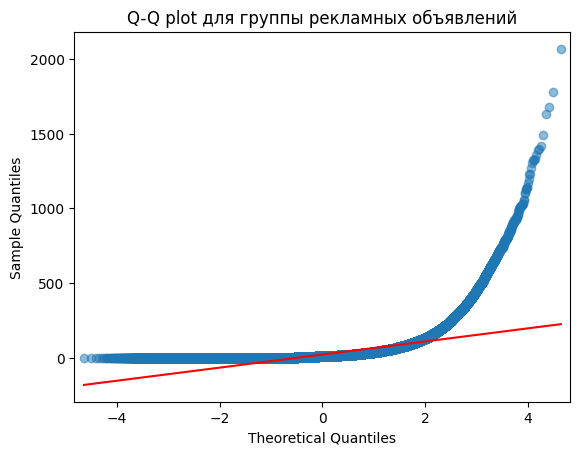

<Figure size 800x400 with 0 Axes>

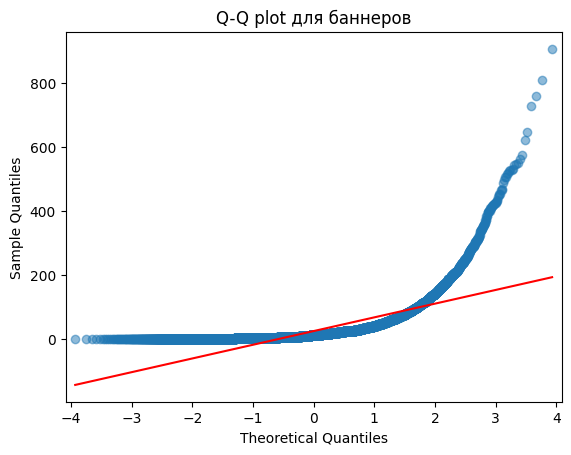

In [ ]:
plt.figure(figsize=(8, 4))
# Строим Q-Q plot для группы рекламных объявлений
sm.qqplot(ad_group['total ads'], line='s', alpha=0.5)
plt.title('Q-Q plot для группы рекламных объявлений')
plt.show()

plt.figure(figsize=(8, 4))
# Строим Q-Q plot для группы баннеров
sm.qqplot(psa_group['total ads'], line='s', alpha=0.5)
plt.title('Q-Q plot для баннеров')
plt.show()

**Вывод**: распределение не нормальное

В таком случае следует использовать критерий Манна-Уитни

In [17]:
ustat, pvalue = stats.mannwhitneyu(ad_group['total ads'], psa_group['total ads'])
print(f"U-тест для количества рекламы: U={ustat}, p-value={pvalue:.4f}")
print("По критерию Манна-Уитни разница в количестве рекламы значительная (т. к. p-value < 0.05)")

U-тест для количества рекламы: U=6808288222.0, p-value=0.0000
По критерию Манна-Уитни разница в количестве рекламы значительная (т. к. p-value < 0.05)


In [18]:
# Далее построим алгоритм для конверсии (z-тест пропорций)
conv_ad = ad_group['converted'].sum() # Т. к. bool значения все равно 0 или 1, то можно просто сложить
conv_psa = psa_group['converted'].sum()
n_ad = len(ad_group)
n_psa = len(psa_group)

zstat, pvalue = proportions_ztest([conv_ad, conv_psa], [n_ad, n_psa])
print(f"\nZ-тест для конверсий: z={zstat:.4f}, p-value={pvalue:.4f}")
print('По z-тесту видно, что в конверсии есть статистически значимая разница')


Z-тест для конверсий: z=7.3701, p-value=0.0000
По z-тесту видно, что в конверсии есть статистически значимая разница


In [ ]:
# 4. Построение доверительных интервалов

# Для разницы конверсий между группами
# Кажется, что сравнение в процентах более репрезентативно, 
# но если сказана разница, пусть будет разница
interval_conv_diff = confint_proportions_2indep(conv_ad, n_ad, conv_psa, n_psa, compare='diff')

print("\n95% доверительные интервалы для конверсий:")
print(f"Разница конверсий в абсолютных величинах: [{interval_conv_diff[0].round(4)}, {interval_conv_diff[1].round(4)}]")


95% доверительные интервалы для конверсий:
Разница конверсий в абсолютных величинах: [0.0059, 0.0094]


In [ ]:
# Для конверсий в каждой группе

interval_conv_ad = proportion_confint(count=conv_ad, 
                          nobs=n_ad)

interval_conv_psa = proportion_confint(count=psa_group['converted'].sum(), 
                           nobs=len(psa_group))

print(f"Группа ad: [{interval_conv_ad[0]:.4f}, {interval_conv_ad[1]:.4f}]")
print(f"Группа psa: [{interval_conv_psa[0]:.4f}, {interval_conv_psa[1]:.4f}]\n")
print('Смотрим на интервалы и видим, что для конверсий данные интервалы не пересекаются')
print('Это говорит о подтверждении статистической значимости данных различий')

Группа ad: [0.0251, 0.0260]
Группа psa: [0.0162, 0.0195]

Смотрим на интервалы и видим, что для конверсий данные интервалы не пересекаются
Это говорит о подтверждении статистической значимости данных различий


In [29]:
# Для среднего количества рекламы
# Определение t-интервала невозможно, т.к. данные не нормальные
# Определелим через bootstrap
def bootstrap_ci(data):
    res = stats.bootstrap((data,), np.mean, n_resamples=1000, method='percentile')
    return res.confidence_interval

inteval_ads = bootstrap_ci(ad_group['total ads'])
inteval_psa = bootstrap_ci(psa_group['total ads'])

print(f"Доверительный интервал среднего количества рекламы для группы рекламных объявлений: [{inteval_ads[0]:.2f}, {inteval_ads[1]:.2f}]")
print(f"Доверительный интервал среднего количества рекламы для группы баннеров: [{inteval_psa[0]:.2f}, {inteval_psa[1]:.2f}]")
print('В данном случае видно, что есть перекрытие между доверительными интервалами по среднему количеству просмотренной рекламы')
print('Это означает, что статистически значимая разница, которая была установлена критерием Манна-Уитни может быть неверной')

Доверительный интервал среднего количества рекламы для группы рекламных объявлений: [24.71, 24.94]
Доверительный интервал среднего количества рекламы для группы баннеров: [24.22, 25.35]
В данном случае видно, что есть перекрытие между доверительными интервалами по среднему количеству просмотренной рекламы
Это означает, что статистически значимая разница, которая была установлена критерием Манна-Уитни может быть неверной


Почитав подробнее про данные 2 метода я пришел к выводу, что разногласия критерия Манна-Уитни с доверительными интервалами могут быть связаны с различной формой распределения и дизбалансом групп, что и происходит в данном датасете. Следовательно, стоит говорить о том, что распределения скорее не различаются в среднем количестве просмотренной рекламы, однако они различаются в распределении (т. е. пользователи начинают вести себя иначе)

# Выводы из исследования

1) Группа, которой показывали рекламное объявление было на выше, чем в контрольной группе (на 0.6-0.9 п.п.);
2) Критерий Манна-Уитни показал значимое различие в количестве просмотренной рекламы, однако под вопрос данный вывод поставило сравнение доверительных интервалов. Велика вероятность того, что критерий Манна-Уитни уловил разницу в медианах или в распредлении, но не в среднем;
3) Из данного исследования стоит сделать вывод, что данная рекламная кампания эффективна, т. к. она увеличивает конверсию с просмотров.